In [1]:
# code adapted from https://github.com/eriklindernoren/PyTorch-GAN
%cd

/home/kacper


In [4]:
from torch import nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image

cuda = True if torch.cuda.is_available() else False

class Options:
    def __init__(self):
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 64
        self.channels = 3
        self.n_critic = 5
        self.clip_value = 0.01
        self.sample_interval = 400

opt = Options()
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [5]:
model = torch.load("experiments_gan/wgan_generator_epoch_103.pt")
from DeepLearning.Project3.frechet_metric import generate_images_to_path
for i in range(10):
    for j in range(10):
        generate_images_to_path(
            model,
            path = f"images/wgan/fid/{i}/{j}/",
            batch_size = 200,
            latent_size = 100,
            img_size = 64
        )

In [2]:
model_paths = [
    (f"experiments_gan/{model_type}_generator_epoch_{epoch}.pt", model_type, epoch, lr)
    for model_type, lr in zip(
        ["wgan", "wgan2", "wgan3", "wgan4"],
        [0.0002, 0.00005, 0.0001, 0.000025]
    )
    for epoch in [0, 9, 19, 29, 39, 49]    
]

In [ ]:
from DeepLearning.Project3.frechet_metric import generate_images_to_path

for model_path, model_type, epoch, lr in model_paths: 
    for i in range(10):
        for j in range(10):
            generate_images_to_path(
                model = torch.load(model_path),
                path = f"images/wgan_exp/{model_type}/{epoch}/fid/{i}/{j}/",
                batch_size = 200,
                latent_size = 100,
                img_size = 64
            )

In [3]:
from DeepLearning.Project3.frechet_metric import fid_metric

images_paths = [
    (f"images/wgan_exp/{model_type}/{epoch}/fid/", model_type, epoch, lr)
    for _, model_type, epoch, lr in model_paths
]

In [4]:
results = []
for images_path, model_type, epoch, lr in images_paths:
    fid = fid_metric('.data/data0/lsun/bedroom/0', images_path)
    results.append({
        "model_type": model_type,
        "epoch": epoch,
        "lr": lr,
        "fid": fid
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:15<00:00,  4.10it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:10<00:00,  4.45it/s]


In [5]:
import json
with open("wgan_experiment.json", "w") as f:
    json.dump(results, f)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

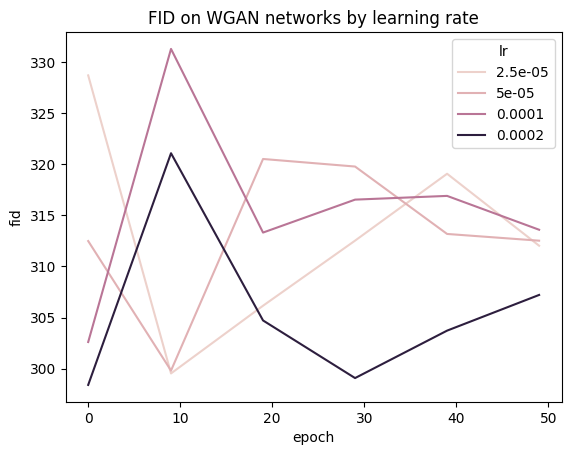

In [12]:
sns.lineplot(pd.DataFrame(results), x="epoch", y="fid", hue="lr")
plt.title("FID on WGAN networks by learning rate")
plt.show()